<a href="https://colab.research.google.com/github/rkrissada/100DayOfMLCode/blob/master/day_035_variational_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Load the dataset
myData = input_data.read_data_sets('MNIST_data')

# Reset graph sessions on the RAM
tf.reset_default_graph()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
BATCH_SIZE = 64

In [0]:
# Batches of MNIST Characters
X_INPUT = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y_OUTPUT = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_FLATTENED = tf.reshape(Y_OUTPUT, shape=[-1, 28*28])
KEEP_PROB = tf.placeholder(dtype=tf.float32, shape=(), name='KEEP_PROB')

# Essential constants
DEC_IN_CHANNELS = 1
NUM_LATENS = 8
RESHAPED_DIM = [-1, 7, 7, DEC_IN_CHANNELS]
INPUTS_DECODER = 24

In [0]:
def encoder(x_input, keep_prob):
    """
        Applies 3 layers of convolutions to the input data with dropout
    """
    with tf.variable_scope("encoder"):

        # Flatten the input
        x = tf.reshape(x_input, shape=[-1, 28, 28, 1])

        # CONV L1
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='SAME', activation=tf.nn.leaky_relu)
        # L1 DROPOUT
        x = tf.nn.dropout(x, keep_prob)

        # CONV L2
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='SAME', activation=tf.nn.leaky_relu)
        # L2 DROPOUT
        x = tf.nn.dropout(x, keep_prob)

        # CONV L3
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='SAME', activation=tf.nn.leaky_relu)
        # L3 DROPOUT
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        x_dense = tf.layers.dense(x, units=NUM_LATENS)
        sd = 0.5 * tf.layers.dense(x, units=NUM_LATENS)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], NUM_LATENS]))
        z = x_dense + tf.multiply(epsilon, tf.exp(sd))

        return z, x_dense, sd

In [0]:
def decoder(sampled_z, keep_prob):
    """
        Regenerate an image using coded images
    """
    with tf.variable_scope("decoder"):
        x = tf.layers.dense(sampled_z, units=INPUTS_DECODER, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=INPUTS_DECODER*2 + 1, activation=tf.nn.leaky_relu)

        x = tf.reshape(x, RESHAPED_DIM)

        # TRANSPOSED CONV 1-3 + DROPOUTS
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)

        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])

        return img

In [7]:
CODED_IMG, MN, SD = encoder(X_INPUT, KEEP_PROB)
DECODED_IMG = decoder(CODED_IMG, KEEP_PROB)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [8]:
# Compute the image reconstruction loss
UN_RESHAPED = tf.reshape(DECODED_IMG, [-1, 28*28])
IMG_LOSS = tf.reduce_sum(tf.squared_difference(UN_RESHAPED, Y_FLATTENED), 1)
LATENT_LOSS = -0.5 * tf.reduce_sum(1.0 + 2.0*SD - tf.square(MN) - tf.exp(2.0*SD), 1)
LOSS = tf.reduce_mean(IMG_LOSS + LATENT_LOSS)
OPTIMIZER = tf.train.AdamOptimizer(0.0005).minimize(LOSS)

Instructions for updating:
Use tf.cast instead.


In [0]:
# Run the session
SESS = tf.Session()
SESS.run(tf.global_variables_initializer())

In [10]:
# Take the minibatches and feed the session dicitionary
for i in range(1500):
    BATCH = [np.reshape(b, [28, 28]) for b in myData.train.next_batch(batch_size=BATCH_SIZE)[0]]
    SESS.run(OPTIMIZER, feed_dict={X_INPUT: BATCH, Y_OUTPUT: BATCH, KEEP_PROB: 0.8})

    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigma = SESS.run([LOSS, DECODED_IMG, IMG_LOSS, LATENT_LOSS, MN, SD],
        feed_dict={X_INPUT: BATCH, Y_OUTPUT: BATCH, KEEP_PROB: 1.0})
        # plt.imshow(np.reshape(BATCH[0], [28, 28]), cmap='gray')
        # plt.show()
        # plt.imshow(d[0], cmap='gray')
        # plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

0 177.702 177.69882 0.0031826962
200 54.71376 53.550648 1.1631124
400 39.744164 34.531273 5.212892
600 33.34879 26.697239 6.6515484
800 36.540756 29.200056 7.340699
1000 32.285725 24.16624 8.119485
1200 32.9044 23.625443 9.278957
1400 33.26073 24.50005 8.760679


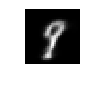

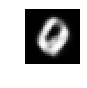

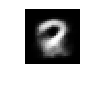

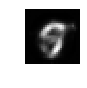

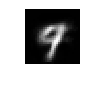

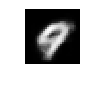

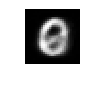

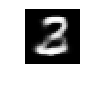

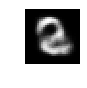

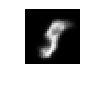

In [11]:
# Generate new handwritten(Written by the machine :D) digits
RANDOM_CODE = [np.random.normal(0, 1, NUM_LATENS) for _ in range(10)]
IMAGES = SESS.run(DECODED_IMG, feed_dict={CODED_IMG: RANDOM_CODE, KEEP_PROB: 1.0})
IMAGES = [np.reshape(IMAGES[i], [28,28]) for i in range(len(IMAGES))]

for img in IMAGES:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()